In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os, re
import cv2
import glob
import pathlib
import time
import datetime
from IPython import display
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

[학습내용]
1. Ablation Study
2. CIFAR-10 데이터셋 준비
3. 블록 구성
4. VGG Complete Model
5. VGG-16 vs VGG-19
6. ResNet Ablation Study

[루브릭]
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
    - 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.


2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
    - tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.


3. Ablation Study 결과가 바른 포맷으로 제출되었는가?
    - ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Ablation Study

## (1) CIFAR-10 데이터셋 준비

### 1) CIFAR-10

In [ ]:
# Tensorflow가 활용할 GPU의 장착 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                        shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteMY5J7N/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteMY5J7N/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [ ]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### 2) Input Normalization

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

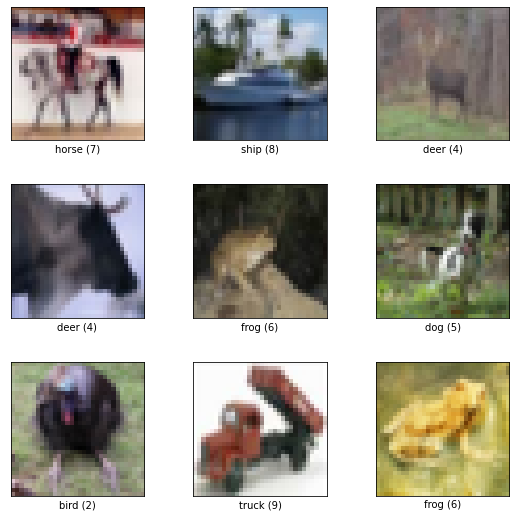

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

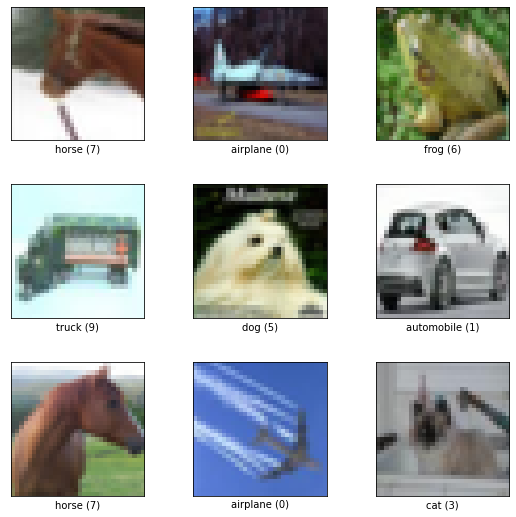

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

## (2) VGG 기본 블록 만들기

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,num_cnn=3, channel=64, block_num=1):
    
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), activation='relu',
            kernel_initializer='he_normal', padding='same', name=f'block{block_num}_conv{cnn_num}')(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name=f'block{block_num}_pooling')(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

## (3) VGG Complete Model

### 1) VGG Model 생성

In [ ]:
# VGG 모델 자체를 생성하는 함수
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만듦
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(output, num_cnn=num_cnn, channel=channel, block_num=i)
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

### 2) VGG-16

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됨
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

### 3) VGG-19

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512],
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## (4) Ablation Study 실습 

### 1) VGG-16

In [ ]:
BATCH_SIZE = 256
EPOCH = 1   #40으로 바꿀 것

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
vgg_16.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.), metrics=['accuracy'])

history_16 = vgg_16.fit(ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

195/195 [==============================] - 45s 131ms/step - loss: 2.2133 - accuracy: 0.1784 - val_loss: 2.0954 - val_accuracy: 0.2514


### 2) VGG-19

In [ ]:
vgg_19.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),metrics=['accuracy'])

history_19 = vgg_19.fit(ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

195/195 [==============================] - 33s 141ms/step - loss: 2.2394 - accuracy: 0.1678 - val_loss: 2.1270 - val_accuracy: 0.2157


### 3) VGG-16 vs. VGG-19 그래프 비교

#### Training Loss

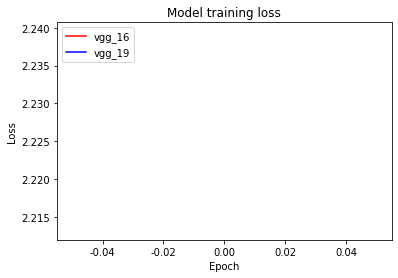

In [ ]:
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

#### Validation Accuracy

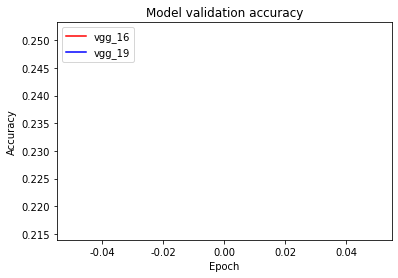

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# 2. Project_ResNet_Ablation_Study

## (1) Cats_vs_Dogs 데이터셋 준비

### 1) Cats_vs_Dogs

In [ ]:
import tensorflow_datasets as tfds

(ds_train, ds_test), metadata = tfds.load('cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteVM6KC1/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


### 2) Input Normalization

In [ ]:
print(ds_train, ds_test, sep='\n')

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


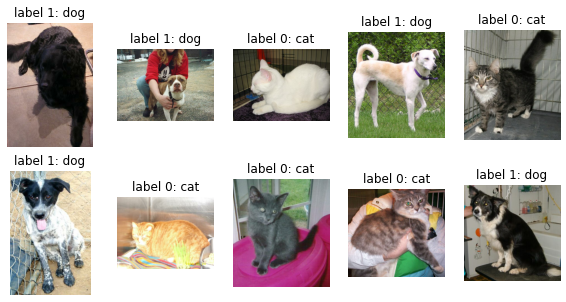

In [ ]:
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str
# take() create new dataset instance as much as parameter
for idx, (image, label) in enumerate(ds_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

#### Image resize

In [ ]:
img_size = 224

def format_example(image, label):
    image = tf.cast(image, tf.float32) # type cast in tensorflow
    image = (image/127.5) - 1 # modify pixel scale -1 ~ 1
    image = tf.image.resize(image, (img_size, img_size))
    return image, label

In [ ]:
train = ds_train.map(format_example)
test = ds_test.map(format_example)

print(train, test, sep='\n')

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


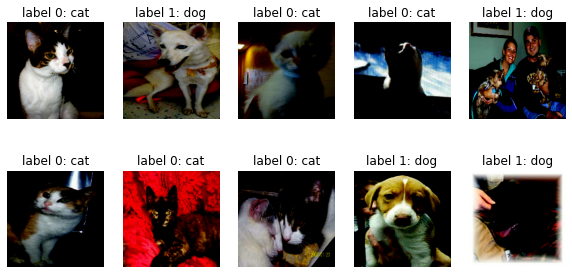

In [ ]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    # image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## (2) ResNet 기본 블록 만들기

In [ ]:
# function for building ResNet Block

def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1, first_block=False):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        if cnn_num == 0:
            if first_block:
                stride = 1
            else:
                stride = 2
            shortcut = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), strides=stride,
                kernel_initializer='he_normal', padding='same', name=f'block{block_num}_shortcut')(x)
            shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_bn_shortcut')(shortcut)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=stride, activation='relu',
            kernel_initializer='he_normal', padding='same', name=f'block{block_num}_conv{cnn_num}')(x)    
        x = keras.layers.BatchNormalization(name=f'block{block_num}_bn{cnn_num}')(x)
        x = keras.layers.Activation('relu', name=f'block{block_num}_relu{cnn_num}')(x)

    # identity connection
    if first_block:
        x = keras.layers.add([x, shortcut], name=f'block{block_num}_add')
    
    return x

In [ ]:
resnet_input_layer = keras.layers.Input(shape=(224,224,3))  # 입력 레이어 생성
resnet_block_output = build_resnet_block(resnet_input_layer)

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv0 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block1_bn0 (BatchNormalizat  (None, 112, 112, 64)     256       
 ion)                                                            
                                                                 
 block1_relu0 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 56, 64)        36928     
                                                                 
 block1_bn1 (BatchNormalizat  (None, 56, 56, 64)       256       
 ion)                                                      

## (3) ResNet Complete Model

### 1) ResNet Model 생성

In [ ]:
def build_resnet(input_shape, num_blocks=[3, 4, 6, 3], num_classes=2):
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # Conv2D
    x = keras.layers.Conv2D(64, (7,7), strides=2, padding='same', name='conv1')(input_layer)
    x = keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = keras.layers.Activation('relu')(x)
    
    # MaxPooling2D
    x = keras.layers.MaxPooling2D((3,3), strides=2, padding='same', name='max_pool')(x)
    
    # ResNet Block x3 (64, [64, 64, 256]) 
    x = build_resnet_block(x, num_cnn=3, channel=64, block_num=2, first_block=True)
    for i in range(num_blocks[0]-1):
        x = build_resnet_block(x, num_cnn=3, channel=64, block_num=i+3, first_block=False)
    
    # ResNet Block x4 (128, [128, 128, 512]) 
    x = build_resnet_block(x, num_cnn=3, channel=128, block_num=6, first_block=True)
    for i in range(num_blocks[1]-1):
        x = build_resnet_block(x, num_cnn=3, channel=128, block_num=i+7, first_block=False)
    
    # ResNet Block x6 (256, [256, 256, 1024]) 
    x = build_resnet_block(x, num_cnn=3, channel=256, block_num=12, first_block=True)
    for i in range(num_blocks[2]-1):
        x = build_resnet_block(x, num_cnn=3, channel=256, block_num=i+13, first_block=False)
    
    # ResNet Block x3 (512, [512, 512, 2048]) 
    x = build_resnet_block(x, num_cnn=3, channel=512, block_num=24, first_block=True)
    for i in range(num_blocks[3]-1):
        x = build_resnet_block(x, num_cnn=3, channel=512, block_num=i+25, first_block=False)
    
    # AveragePooling2D
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Dense
    x = keras.layers.Dense(num_classes, activation='softmax', name='fc')(x)
    
    # model 생성
    model = keras.models.Model(inputs=input_layer, outputs=x)
    
    return model

### 2) ResNet-34

In [ ]:
resnet34 = build_resnet(input_shape=(224, 224, 3), num_blocks=[3, 4, 6, 3], num_classes=2)
resnet34.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                           

### 3) ResNet-50

In [ ]:
resnet50 = build_resnet(input_shape=(224, 224, 3), num_blocks=[3, 4, 6, 3], num_classes=2)
resnet50.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                           

## (4) Ablation Study 실습

### 1) 일반 네트워크(plain network) 만들기

ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요함

#### 블록 코드 수정

In [ ]:
def build_plain_block(input_layer, num_cnn=3, channel=64, block_num=1):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), activation='relu',
            kernel_initializer='he_normal', padding='same', name=f'block{block_num}_conv{cnn_num}')(x)    
        x = keras.layers.BatchNormalization(name=f'block{block_num}_bn{cnn_num}')(x)
        x = keras.layers.Activation('relu', name=f'block{block_num}_relu{cnn_num}')(x)
    
    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name=f'block{block_num}_pooling')(x)
    
    return x

In [ ]:
plain_input_layer = keras.layers.Input(shape=(224,224,3))  # 입력 레이어 생성
plain_block_output = build_plain_block(plain_input_layer, num_cnn=3, channel=64, block_num=1)

In [ ]:
# 블록 1개짜리 plain net model 생성
model = keras.Model(inputs=plain_input_layer, outputs=plain_block_output)  

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv0 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_bn0 (BatchNormalizat  (None, 224, 224, 64)     256       
 ion)                                                            
                                                                 
 block1_relu0 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_bn1 (BatchNormalizat  (None, 224, 224, 64)     256       
 ion)                                                      

#### 전체 함수 코드 수정

입력 이미지의 크기 = (224, 224, 3)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model


def build_plainnet(num_layers, num_classes, input_shape=(224, 224, 3)):
    # Define input layer
    input_layer = Input(shape=input_shape)
    
    # Define number of filters for each block
    if num_layers == 34:
        filters = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
    elif num_layers == 50:
        filters = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 1024, 1024, 1024, 2048, 2048, 2048]
    else:
        raise ValueError("PlainNet-{} is not supported.".format(num_layers))
    
    # Define convolutional blocks
    x = input_layer
    for i in range(len(filters)-1):
        x = Conv2D(filters[i], kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i in [1, 4, 7, 10]:
            x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Define last convolutional block
    x = Conv2D(filters[-1], kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Define output layer
    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # Define model
    model = Model(input_layer, output_layer)
    
    return model

In [ ]:
# PlainNet-34 생성
plainnet34 = build_plainnet(input_shape=(224, 224, 3), num_layers=34, num_classes=2)

In [ ]:
# PlainNet-50 생성
plainnet50 = build_plainnet(input_shape=(224, 224, 3), num_layers=50, num_classes=2)

### 2) Ablation Study (ResNet-50 vs. Plain-50)

#### [ResNet-50]

In [ ]:
BATCH_SIZE = 256
EPOCHS = 10

In [ ]:
# Compile the model
resnet50.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Train the model and save training history
history_resnet50 = resnet50.fit(ds_train, epochs=EPOCHS, validation_data=ds_test)

Epoch 1/10


ValueError: ignored

#### [Plain-50]

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

(ds_train, ds_test), metadata = tfds.load('cats_vs_dogs', split=['train[:80%]','train[80%:]'],
                   shuffle_files=True, with_info=True, as_supervised=True)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# Compile the model
plainnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_plainnet50 = plainnet50.fit(ds_train, epochs=EPOCHS, validation_data=ds_test)

#### [ResNet-50 vs. Plain-50 그래프 비교]

##### - Training Loss

In [ ]:
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plainnet50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_50', 'PlainNet_50'], loc='upper left')
plt.show()

##### - Validation Accuracy

In [ ]:
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plainnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_50', 'PlainNet_50'], loc='upper left')
plt.show()

# 4. References

[1] ResNet https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

[2] DenseNet https://arxiv.org/abs/1608.06993

[3] SENet https://arxiv.org/abs/1709.01507

[4] 모델최적화(1)_NASNet https://arxiv.org/abs/1707.07012

[5] 모델최적화(2)_EfficientNet https://arxiv.org/abs/1905.11946

[6] https://lms.aiffel.io/course/405/node/462